In [1]:
def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [5]:
import lightgbm
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

train = pd.read_csv("train.csv",sep=',')
test = pd.read_csv("test.csv",sep=',')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
columns_to_normalize = ['device', 'geoNetwork','totals', 'trafficSource']
def normalize_json_data(filename):
    path = filename
    df = pd.read_csv(path, converters={column: json.loads for column in columns_to_normalize}, 
                     dtype={'fullVisitorId': 'str'})
    
    for column in columns_to_normalize:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

train = normalize_json_data("train.csv")
test = normalize_json_data("test.csv")

In [7]:
train.shape

(903653, 55)

In [8]:
test.shape

(804684, 53)

In [9]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device_browser', 'device_browserSize', 'device_browserVersion',
       'device_deviceCategory', 'device_flashVersion', 'device_isMobile',
       'device_language', 'device_mobileDeviceBranding',
       'device_mobileDeviceInfo', 'device_mobileDeviceMarketingName',
       'device_mobileDeviceModel', 'device_mobileInputSelector',
       'device_operatingSystem', 'device_operatingSystemVersion',
       'device_screenColors', 'device_screenResolution', 'geoNetwork_city',
       'geoNetwork_cityId', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_latitude', 'geoNetwork_longitude', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_networkLocation',
       'geoNetwork_region', 'geoNetwork_subContinent', 'totals_bounces',
       'totals_hits', 'totals_newVisits', 'totals_pageviews',
       'totals_transactionRevenue

In [12]:
train.corr(method='pearson')

,date,visitId,visitNumber,visitStartTime,device_isMobile
date,1.000000,0.880936,0.007536,0.880936,0.146148
visitId,0.880936,1.000000,0.002069,1.000000,0.144332
visitNumber,0.007536,0.002069,1.000000,0.002069,-0.037667
visitStartTime,0.880936,1.000000,0.002069,1.000000,0.144332
device_isMobile,0.146148,0.144332,-0.037667,0.144332,1.000000


In [13]:
train_numerical_features = train.select_dtypes(include=[np.number])

In [14]:
train_numerical_features.columns


Index(['date', 'visitId', 'visitNumber', 'visitStartTime'], dtype='object')

In [15]:
test_numerical_features = test.select_dtypes(include=[np.number])

In [16]:
test_numerical_features.columns

Index(['date', 'visitId', 'visitNumber', 'visitStartTime'], dtype='object')

In [17]:
train_category_features = train.select_dtypes(include=[np.object])
test_category_features = test.select_dtypes(include=[np.object])
train_category_features.columns
test_category_features.columns

Index(['channelGrouping', 'fullVisitorId', 'sessionId', 'socialEngagementType',
       'device_browser', 'device_browserSize', 'device_browserVersion',
       'device_deviceCategory', 'device_flashVersion', 'device_language',
       'device_mobileDeviceBranding', 'device_mobileDeviceInfo',
       'device_mobileDeviceMarketingName', 'device_mobileDeviceModel',
       'device_mobileInputSelector', 'device_operatingSystem',
       'device_operatingSystemVersion', 'device_screenColors',
       'device_screenResolution', 'geoNetwork_city', 'geoNetwork_cityId',
       'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_latitude',
       'geoNetwork_longitude', 'geoNetwork_metro', 'geoNetwork_networkDomain',
       'geoNetwork_networkLocation', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_visits',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
     

In [18]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,...,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [19]:
train.shape
test.shape

(804684, 53)

In [20]:
test.shape

(804684, 53)

In [21]:
train.shape

(903653, 55)

In [22]:
train = train.loc[:, (train != train.iloc[0]).any()]
test = test.loc[:, (test != test.iloc[0]).any()]

In [23]:
print(train.shape, test.shape)

(903653, 36) (804684, 34)


In [24]:
train["totals_transactionRevenue"] = train["totals_transactionRevenue"].astype('float')

In [32]:
for df in [train, test]:
    df['v_date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['dayofweek'] = df['v_date'].dt.dayofweek
    df['hours'] = df['v_date'].dt.hour
    df['day'] = df['v_date'].dt.day
    df.drop('visitStartTime', axis=1)

In [33]:
print(train.shape, test.shape)

(903653, 42) (804684, 38)


In [35]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,...,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,month,day,weekday,v_date,dayofweek,hours
0,Organic Search,2016------0-9-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,...,(not provided),organic,NaN,google,9,2,4,2016-09-02 15:33:05,4,15
1,Organic Search,2016------0-9-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,...,(not provided),organic,NaN,google,9,3,4,2016-09-03 05:22:27,5,5
2,Organic Search,2016------0-9-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,...,(not provided),organic,NaN,google,9,3,4,2016-09-03 01:16:26,5,1
3,Organic Search,2016------0-9-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,...,google + online,organic,NaN,google,9,3,4,2016-09-03 05:40:13,5,5
4,Organic Search,2016------0-9-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,...,(not provided),organic,NaN,google,9,2,4,2016-09-02 13:23:20,4,13


In [36]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

agg_dict = {}
for col in ["totals_bounces", "totals_hits", "totals_newVisits", "totals_pageviews", "totals_transactionRevenue"]:
    train[col] = train[col].astype('float')
    agg_dict[col] = "sum"
tmp = train.groupby("fullVisitorId").agg(agg_dict).reset_index()
tmp.head()

,fullVisitorId,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue
0,0000010278554503158,0.0,11.0,1.0,8.0,0.0
1,0000020424342248747,0.0,17.0,1.0,13.0,0.0
2,0000027376579751715,0.0,6.0,1.0,5.0,0.0
3,0000039460501403861,0.0,2.0,1.0,2.0,0.0
4,0000040862739425590,0.0,5.0,1.0,5.0,0.0


In [52]:
constant_columns = []
for column in train.columns:
    if len(train[column].value_counts()) == 1:
        constant_columns.append(column)

irrelevant_columns = ["visitNumber", "date", "fullVisitorId", "sessionId", "visitId", "visitStartTime", "v_date", 
                      "month", "weekday"]



In [53]:
colms = irrelevant_columns + constant_columns

In [54]:

colms

['visitNumber',
 'date',
 'fullVisitorId',
 'sessionId',
 'visitId',
 'visitStartTime',
 'v_date',
 'month',
 'weekday',
 'totals_bounces',
 'totals_newVisits',
 'trafficSource_adwordsClickInfo.isVideoAd',
 'trafficSource_campaignCode',
 'trafficSource_isTrueDirect']

In [57]:
from sklearn.preprocessing import LabelEncoder

category_columns = [c for c in train.columns if not c.startswith("total")]
category_columns = [c for c in category_columns if c not in colms]

#print(category_columns)

for c in category_columns:

    labelencode = LabelEncoder()
    train_vals = list(train[c].values.astype(str))
    test_vals = list(test[c].values.astype(str))
    
    labelencode.fit(train_vals + test_vals)
    
    train[c] = labelencode.transform(train_vals)
    test[c] = labelencode.transform(test_vals)

In [56]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,...,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,month,day,weekday,v_date,dayofweek,hours
0,4,2016------0-9-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,13,0,0,...,147,5,1678,332,8,3,4,2016-09-02 15:33:05,4,7
1,4,2016------0-9-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,18,0,0,...,147,5,1678,332,8,15,4,2016-09-03 05:22:27,5,19
2,4,2016------0-9-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,13,0,0,...,147,5,1678,332,8,15,4,2016-09-03 01:16:26,5,1
3,4,2016------0-9-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,55,0,0,...,125,5,1678,332,8,15,4,2016-09-03 05:40:13,5,19
4,4,2016------0-9-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,13,1,1,...,147,5,1678,332,8,3,4,2016-09-02 13:23:20,4,5


In [58]:
def normalize_numerical_columns(df, isTrain = True):
    df["totals_hits"] = df["totals_hits"].astype(float)
    df["totals_hits"] = (df["totals_hits"] - min(df["totals_hits"])) / (max(df["totals_hits"]) - min(df["totals_hits"]))

    df["totals_pageviews"] = df["totals_pageviews"].astype(float)
    df["totals_pageviews"] = (df["totals_pageviews"] - min(df["totals_pageviews"])) / (max(df["totals_pageviews"]) - min(df["totals_pageviews"]))
    
    if isTrain:
        df["totals_transactionRevenue"] = df["totals_transactionRevenue"].fillna(0.0)
    return df 

In [59]:
train = normalize_numerical_columns(train)
test = normalize_numerical_columns(test, isTrain = False)

In [60]:
from sklearn.model_selection import train_test_split
features = [c for c in train.columns if c not in colms]
features.remove("totals_transactionRevenue")
train["totals_transactionRevenue"] = np.log1p(train["totals_transactionRevenue"].astype(float))

In [61]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,...,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,month,day,weekday,v_date,dayofweek,hours
0,4,2016------0-9-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,14,0,0,...,524,5,755,260,8,23,4,2016-09-02 15:33:05,4,21
1,4,2016------0-9-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,19,0,0,...,524,5,755,260,8,7,4,2016-09-03 05:22:27,5,11
2,4,2016------0-9-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,14,0,0,...,524,5,755,260,8,7,4,2016-09-03 01:16:26,5,1
3,4,2016------0-9-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,60,0,0,...,280,5,755,260,8,7,4,2016-09-03 05:40:13,5,11
4,4,2016------0-9-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,14,1,1,...,524,5,755,260,8,23,4,2016-09-02 13:23:20,4,19


In [62]:
print(train.corrwith(train['totals_transactionRevenue']))

channelGrouping                                -0.000807
visitId                                         0.010491
visitNumber                                     0.023666
visitStartTime                                  0.010491
device_browser                                 -0.047720
device_deviceCategory                          -0.042843
device_isMobile                                -0.046071
device_operatingSystem                         -0.032188
geoNetwork_city                                -0.034703
geoNetwork_continent                           -0.088376
geoNetwork_country                              0.057219
geoNetwork_metro                                0.075081
geoNetwork_networkDomain                       -0.074516
geoNetwork_region                               0.040322
geoNetwork_subContinent                        -0.044378
totals_bounces                                       NaN
totals_hits                                     0.378804
totals_newVisits               

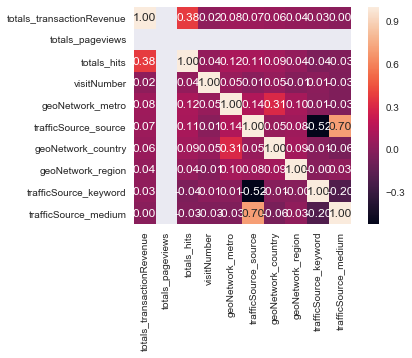

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
spearman_correlation = train.corr(method='spearman')
pick_columns=spearman_correlation.nlargest(10, 'totals_transactionRevenue').index
correlationmap = np.corrcoef(train[pick_columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlationmap, cbar=True, annot=True, square=True , fmt='.2f', 
                      yticklabels=pick_columns.values, xticklabels=pick_columns.values)
plt.show()

In [68]:
train_x, valid_x, train_y, valid_y = train_test_split(train[features], train["totals_transactionRevenue"], 
                                     test_size=0.25, random_state=20)

In [71]:
import lightgbm as lgb 

lgb_params = {"objective" : "regression", "metric" : "rmse",
              "num_leaves" : 50, "learning_rate" : 0.02, 
              "bagging_fraction" : 0.75, "feature_fraction" : 0.8, "bagging_frequency" : 9}
    
lgb_train = lgb.Dataset(train_x, label=train_y)
lgb_val = lgb.Dataset(valid_x, label=valid_y)
model = lgb.train(lgb_params, lgb_train, 700, valid_sets=[lgb_val], early_stopping_rounds=250, verbose_eval=100)

Training until validation scores don't improve for 250 rounds.
[100]	valid_0's rmse: 1.68408
[200]	valid_0's rmse: 1.66058
[300]	valid_0's rmse: 1.65629
[400]	valid_0's rmse: 1.6556
[500]	valid_0's rmse: 1.65574
[600]	valid_0's rmse: 1.65559
Early stopping, best iteration is:
[357]	valid_0's rmse: 1.65547


In [72]:
model = lgb.train(lgb_params, lgb_train, 700, valid_sets=[lgb_val], early_stopping_rounds=250, verbose_eval=100)

Training until validation scores don't improve for 250 rounds.
[100]	valid_0's rmse: 1.68408
[200]	valid_0's rmse: 1.66058
[300]	valid_0's rmse: 1.65629
[400]	valid_0's rmse: 1.6556
[500]	valid_0's rmse: 1.65574
[600]	valid_0's rmse: 1.65559
Early stopping, best iteration is:
[357]	valid_0's rmse: 1.65547


In [73]:
test_prediction = model.predict(test[features], num_iteration=model.best_iteration)
test["PredictedLogRevenue"] = np.expm1(test_prediction)
submission = test.groupby("fullVisitorId").agg({"PredictedLogRevenue" : "sum"}).reset_index()
submission["PredictedLogRevenue"] = np.log1p(submission["PredictedLogRevenue"])
submission["PredictedLogRevenue"] =  submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission.to_csv("submission2.csv", index=False)
submission.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log1p
  after removing the cwd from sys.path.


,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.138513
1,0000049363351866189,0.000000
2,0000053049821714864,0.000000
3,0000059488412965267,0.000000
4,0000085840370633780,0.009529


In [74]:
preds = model.predict(test[features], num_iteration=model.best_iteration)
test["PredictedLogRevenue"] = np.expm1(preds)
submission = test.groupby("fullVisitorId").agg({"PredictedLogRevenue" : "sum"}).reset_index()
submission["PredictedLogRevenue"] = np.log1p(submission["PredictedLogRevenue"])
submission["PredictedLogRevenue"] =  submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission.to_csv("baseline.csv", index=False)
submission.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log1p
  after removing the cwd from sys.path.


,fullVisitorId,PredictedLogRevenue
0,0000000259678714014,0.138513
1,0000049363351866189,0.000000
2,0000053049821714864,0.000000
3,0000059488412965267,0.000000
4,0000085840370633780,0.009529


In [75]:
lgb_param = {'num_leaves':48,
         'min_data_in_leaf': 300, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate':0.005,
         "min_child_samples":40,
         "boosting":"gbdt",
         "feature_fraction":0.8,
         "bagging_freq":1,
         "bagging_fraction":0.8 ,
         "bagging_seed": 3,
         "metric": 'rmse',
         "lambda_l1": 1,
         'lambda_l2': 1,
         "verbosity": -1}

lgb_train = lgb.Dataset(train_x, label=train_y)
lgb_val = lgb.Dataset(valid_x, label=valid_y)
model = lgb.train(lgb_params, lgb_train, 700, valid_sets=[lgb_val], early_stopping_rounds=250, verbose_eval=100)

Training until validation scores don't improve for 250 rounds.
[100]	valid_0's rmse: 1.68408
[200]	valid_0's rmse: 1.66058
[300]	valid_0's rmse: 1.65629
[400]	valid_0's rmse: 1.6556
[500]	valid_0's rmse: 1.65574
[600]	valid_0's rmse: 1.65559
Early stopping, best iteration is:
[357]	valid_0's rmse: 1.65547


In [76]:
train_df = train
test_df = test

In [78]:
train_df.shape

(903653, 42)

In [81]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_campaignCode', 'trafficSource_isTrueDirect',
       'trafficSource_keyword', 'trafficSource_medium',
       'trafficSource_referralPath', 'trafficSource_source', 'month', '

In [83]:
target = train_df['totals_transactionRevenue']

In [85]:
target = train_df['totals_transactionRevenue'].fillna(0).astype(float)
target = target.apply(lambda x: np.log(x) if x > 0 else x)
del train_df['totals_transactionRevenue']

In [91]:
param = {'num_leaves':48,
         'min_data_in_leaf': 300, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate':0.005,
         "min_child_samples":40,
         "boosting":"gbdt",
         "feature_fraction":0.8,
         "bagging_freq":1,
         "bagging_fraction":0.8 ,
         "bagging_seed": 3,
         "metric": 'rmse',
         "lambda_l1": 1,
         'lambda_l2': 1,
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
start = time.time()
features_c = list(train_df.columns)
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    trn_data = lgb.Dataset(train_df.iloc[trn_idx], label=target.iloc[trn_idx], categorical_feature=features)
    val_data = lgb.Dataset(train_df.iloc[val_idx], label=target.iloc[val_idx], categorical_feature=features)
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=400, early_stopping_rounds = 500, categorical_feature=features)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx].values, num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features_c
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df.values, num_iteration=clf.best_iteration) / folds.n_splits

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields date, fullVisitorId, sessionId, trafficSource_adwordsClickInfo.isVideoAd, trafficSource_campaignCode, trafficSource_isTrueDirect, v_date

In [90]:
(features)

['channelGrouping',
 'date',
 'fullVisitorId',
 'sessionId',
 'visitId',
 'visitNumber',
 'visitStartTime',
 'device_browser',
 'device_deviceCategory',
 'device_isMobile',
 'device_operatingSystem',
 'geoNetwork_city',
 'geoNetwork_continent',
 'geoNetwork_country',
 'geoNetwork_metro',
 'geoNetwork_networkDomain',
 'geoNetwork_region',
 'geoNetwork_subContinent',
 'totals_bounces',
 'totals_hits',
 'totals_newVisits',
 'totals_pageviews',
 'trafficSource_adContent',
 'trafficSource_adwordsClickInfo.adNetworkType',
 'trafficSource_adwordsClickInfo.gclId',
 'trafficSource_adwordsClickInfo.isVideoAd',
 'trafficSource_adwordsClickInfo.page',
 'trafficSource_adwordsClickInfo.slot',
 'trafficSource_campaign',
 'trafficSource_campaignCode',
 'trafficSource_isTrueDirect',
 'trafficSource_keyword',
 'trafficSource_medium',
 'trafficSource_referralPath',
 'trafficSource_source',
 'month',
 'day',
 'weekday',
 'v_date',
 'dayofweek',
 'hours']

In [93]:
features.remove('date')
#['date', 'fullVisitorId', 'sessionId', 'trafficSource_adwordsClickInfo.isVideoAd', 
            #'trafficSource_campaignCode', 'trafficSource_isTrueDirect', 'v_date']

In [95]:
rem = ['date','fullVisitorId', 'sessionId', 'trafficSource_adwordsClickInfo.isVideoAd', 
            'trafficSource_campaignCode', 'trafficSource_isTrueDirect', 'v_date']
for i in rem:
    features_c.remove(i)


In [97]:
param = {'num_leaves':48,
         'min_data_in_leaf': 300, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate':0.005,
         "min_child_samples":40,
         "boosting":"gbdt",
         "feature_fraction":0.8,
         "bagging_freq":1,
         "bagging_fraction":0.8 ,
         "bagging_seed": 3,
         "metric": 'rmse',
         "lambda_l1": 1,
         'lambda_l2': 1,
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
start = time.time()
features_c = list(train_df.columns)

rem = ['date','fullVisitorId', 'sessionId', 'trafficSource_adwordsClickInfo.isVideoAd', 
            'trafficSource_campaignCode', 'trafficSource_isTrueDirect', 'v_date']
for i in rem:
    features_c.remove(i)

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    trn_data = lgb.Dataset(train_df.iloc[trn_idx], label=target.iloc[trn_idx], categorical_feature=features)
    val_data = lgb.Dataset(train_df.iloc[val_idx], label=target.iloc[val_idx], categorical_feature=features)
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=400, early_stopping_rounds = 500, categorical_feature=features)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx].values, num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features_c
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df.values, num_iteration=clf.best_iteration) / folds.n_splits

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields date, fullVisitorId, sessionId, trafficSource_adwordsClickInfo.isVideoAd, trafficSource_campaignCode, trafficSource_isTrueDirect, v_date

In [98]:
train_fullVisitorId = train['fullVisitorId']
train_sessionId = train['sessionId']
train_visitId = train['visitId']

test_fullVisitorId = test['fullVisitorId']
test_sessionId = test['sessionId']
test_visitId = test['visitId']

In [102]:
lgb_param = {'num_leaves':48,
         'min_data_in_leaf': 300, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate':0.005,
         "min_child_samples":40,
         "boosting":"gbdt",
         "feature_fraction":0.8,
         "bagging_freq":1,
         "bagging_fraction":0.8 ,
         "bagging_seed": 3,
         "metric": 'rmse',
         "lambda_l1": 1,
         'lambda_l2': 1,
         "verbosity": -1}

lgb_train = lgb.Dataset(train_x, label=train_y)
lgb_val = lgb.Dataset(valid_x, label=valid_y)
model = lgb.train(lgb_params, lgb_train, 700, valid_sets=[lgb_val], early_stopping_rounds=250, verbose_eval=100)


test_prediction = model.predict(test[features], num_iteration=model.best_iteration)
test["PredictedLogRevenue"] = np.expm1(test_prediction)

Training until validation scores don't improve for 250 rounds.
[100]	valid_0's rmse: 1.68408
[200]	valid_0's rmse: 1.66058
[300]	valid_0's rmse: 1.65629
[400]	valid_0's rmse: 1.6556
[500]	valid_0's rmse: 1.65574
[600]	valid_0's rmse: 1.65559
Early stopping, best iteration is:
[357]	valid_0's rmse: 1.65547


KeyError: "['month' 'weekday'] not in index"

KeyError: "['month' 'weekday'] not in index"

In [105]:
submission = pd.DataFrame()
submission['fullVisitorId'] = test_fullVisitorId
submission['PredictedLogRevenue'] = predictions
grouped_test = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
grouped_test.to_csv('submit_4.csv',index=False)

In [113]:
geo_cols = ["geoNetwork_city", "geoNetwork_country", "geoNetwork_subContinent", "geoNetwork_continent"]
colors = ["#d6a5ff", "#fca6da", "#f4d39c", "#a9fcca"]
traces = []
for i, col in enumerate(geo_cols):
    t = train[col].value_counts()
    traces.append(go.Bar(marker=dict(color=colors[i]),orientation="h", y = t.index[:15], x = t.values[:15]))

fig = tools.make_subplots(rows=2, cols=2, 
                          subplot_titles=["Visits: City", "Visits: Country","Visits: Sub Continent","Visits: Continent"]
                          , print_grid=False)
fig.append_trace(traces[0], 1, 1)
fig.append_trace(traces[1], 1, 2)
fig.append_trace(traces[2], 2, 1)
fig.append_trace(traces[3], 2, 2)

fig['layout'].update(height=600,width=1000, showlegend=False)
iplot(fig)



In [109]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools

In [127]:
geo_cols = ["geoNetwork_city", "geoNetwork_country", "geoNetwork_subContinent", "geoNetwork_continent"]
colors = ["red", "green", "purple","blue"]
traces = []
for i, col in enumerate(geo_cols):
    t = train[col].value_counts()
    traces.append(go.Bar(marker=dict(color=colors[i]),orientation="h", y = t.index[:15], x = t.values[:15]))

fig = tools.make_subplots(rows=2, cols=2, 
                          subplot_titles=["Visits: City", "Visits: Country","Visits: Sub Continent","Visits: Continent"]
                          , print_grid=False)
fig.append_trace(traces[0], 1, 1)
fig.append_trace(traces[1], 1, 2)
fig.append_trace(traces[2], 2, 1)
fig.append_trace(traces[3], 2, 2)

fig['layout'].update(height=600,width=1000, showlegend=False)
iplot(fig)



In [116]:
import matplotlib.pyplot as plt

In [124]:
#Import      Section
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Import matplotlib & seaborn for visualisation
import json
from pandas.io.json import json_normalize
import seaborn as sns 
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
import numpy as np
init_notebook_mode(connected=True)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st


In [128]:
df_train = pd.read_csv("train.csv")

df_test = pd.read_csv("test.csv")

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [130]:
json_columns = ['device', 'geoNetwork','totals', 'trafficSource']
def dataframe(filename):
    path = filename
    df = pd.read_csv(path, converters={column: json.loads for column in json_columns}, 
                     dtype={'fullVisitorId': 'str'})
    
    for column in json_columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

train = dataframe("train.csv")
test = dataframe("test.csv")

In [131]:
train = train.loc[:, (train != train.iloc[0]).any()]

test = test.loc[:, (test != test.iloc[0]).any()]

In [132]:
train.columns


Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_campaignCode', 'trafficSource_isTrueDirect',
       'trafficSource_keyword', 'trafficSource_medium',
       'trafficSource_referralPath', 'trafficSource_source'],
      dty

In [148]:
geo_cols = ["geoNetwork_metro", "geoNetwork_city", "geoNetwork_country", "geoNetwork_subContinent", "geoNetwork_continent"]
colors = ["red", "green", "purple","blue", "yellow"]
traces = []
for i, col in enumerate(geo_cols):
    t = train[col].value_counts()
    traces.append(go.Bar(marker=dict(color=colors[i]),orientation="h", y = t.index[:15], x = t.values[:15]))

fig = tools.make_subplots(rows=3, cols=2, 
                          subplot_titles=["Visits: Metro", "Visits: City", "Visits: Country","Visits: Sub Continent","Visits: Continent"]
                          , print_grid=False)
fig.append_trace(traces[0], 1, 1)
fig.append_trace(traces[1], 1, 2)
fig.append_trace(traces[2], 2, 1)
fig.append_trace(traces[3], 2, 2)
fig.append_trace(traces[4], 3, 1)

fig['layout'].update(height=600,width=1000, showlegend=False)
iplot(fig)

train["totals_transactionRevenue"] = train["totals_transactionRevenue"].astype('float')

fig = tools.make_subplots(rows=3, cols=2, subplot_titles=["Mean Revenue by Metro", "Mean Revenue by City", "Mean Revenue by Country","Mean Revenue by Sub Continent","Mean Revenue by Continent"], print_grid=False)


trs = []
for i, col in enumerate(geo_cols):
    tmp = train.groupby(col).agg({"totals_transactionRevenue": "mean"}).reset_index().rename(columns={"totals_transactionRevenue" : "Mean Revenue"})
    tmp = tmp.dropna()
    tr = go.Bar(x = tmp["Mean Revenue"], orientation="h", marker=dict(opacity=0.5, color=colors[i]), y = tmp[col])
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig.append_trace(trs[2], 2, 1)
fig.append_trace(trs[3], 2, 2)
fig.append_trace(trs[4], 3, 1)

fig['layout'].update(height=600,width=1000, showlegend=False)
iplot(fig)

In [154]:
geo_info = ["geoNetwork_metro", "geoNetwork_city", "geoNetwork_country", 
            "geoNetwork_subContinent", "geoNetwork_continent"]

colors = ["red", "green", "purple","blue", "yellow"]
traces = []

for i, col in enumerate(geo_info):
    t = train[col].value_counts()
    traces.append(go.Bar(marker=dict(color=colors[i]),orientation="h", y = t.index[:15], x = t.values[:15]))

fig = tools.make_subplots(rows=3, cols=2, 
                          subplot_titles=["Count: Metro", "Count: City", "Count: Country",
                                          "Count: Sub Continent", "Count: Continent"]
                          , print_grid=False)

fig.append_trace(traces[0], 1, 1)
fig.append_trace(traces[1], 1, 2)
fig.append_trace(traces[2], 2, 1)
fig.append_trace(traces[3], 2, 2)
fig.append_trace(traces[4], 3, 1)

fig['layout'].update(height=600,width=1000, showlegend=False)
iplot(fig)

train["totals_transactionRevenue"] = train["totals_transactionRevenue"].astype('float')

fig = tools.make_subplots(rows=3, cols=2, subplot_titles=["Avg NonZero TranRevenue by Metro", 
                                                          "Avg NonZero TranRevenue by City", 
                                                          "Avg NonZero TranRevenue by Country",
                                                          "Avg NonZero TranRevenue by Sub-Continent",
                                                          "Avg NonZero TranRevenue by Continent"], 
                                                          print_grid=False)


trs = []
for i, col in enumerate(geo_info):
    tmp = train.groupby(col).agg({"totals_transactionRevenue": "mean"}).reset_index().rename(columns={"totals_transactionRevenue" : 
                                                                                                      "Mean Revenue"})
    tmp = tmp.dropna()
    tr = go.Bar(x = tmp["Mean Revenue"], orientation="h", marker=dict(opacity=0.5, color=colors[i]), y = tmp[col])
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig.append_trace(trs[2], 2, 1)
fig.append_trace(trs[3], 2, 2)
fig.append_trace(trs[4], 3, 1)

fig['layout'].update(height=600,width=1000, showlegend=False)
iplot(fig)

In [158]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,...,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [159]:
def extractdate(df):
    df['date'] = df['date'].astype(str)
    df["date"] = df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    df["date"] = pd.to_datetime(df["date"])
    
    df["month"]   = df['date'].dt.month
    df["day"]     = df['date'].dt.day
    df["weekday"] = df['date'].dt.weekday
    return df

train=extractdate(train)

In [160]:
test=extractdate(test)

In [162]:
const_cols = [c for c in train.columns if train[c].nunique(dropna=False)==1 ]
const_cols

[]

In [165]:
fig = tools.make_subplots(rows=1, cols=2,subplot_titles=["Traffic Source Campaign (not-set removed)", 
                                                         "Traffic Source Medium"], print_grid=False)
 
colors = ["Red", "Red", "blue", "green"]
t1 = train["trafficSource_campaign"].value_counts()
t2 = train["trafficSource_medium"].value_counts()

tr1 = go.Bar(x = t1.index, y = t1.values, marker=dict(color=colors[1]))
tr2 = go.Bar(x = t2.index, y = t2.values, marker=dict(color=colors[2]))

fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)


fig['layout'].update(height=400, margin=dict(b=100), showlegend=False)
iplot(fig)

In [181]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

In [182]:
count_source = train.groupby('device_browser')['totals_transactionRevenue'].agg(['size', 'count', 'mean'])
count_source.columns = ["count", "non-zero TranRevenue Count", "Mean"]
count_source = count_source.sort_values(by="count", ascending=False)
t1 = horizontal_bar_chart(count_source["count"].head(10), 'rgba(50, 171, 96, 0.6)')
t2 = horizontal_bar_chart(count_source["non-zero TranRevenue Count"].head(10), 'rgba(50, 171, 96, 0.6)')
t3 = horizontal_bar_chart(count_source["Mean"].head(10), 'rgba(50, 171, 96, 0.6)')

fig.append_trace(t1, 1, 1)
fig.append_trace(t2, 1, 2)
#fig.append_trace(t3, 1, 3)

fig['layout'].update(height=900, width=900, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
iplot(fig, filename='device-plots')

In [183]:
fig = tools.make_subplots(rows=1, cols=2,subplot_titles=["Traffic Source Campaign (not-set removed)", 
                                                         "Traffic Source Medium"], print_grid=False)
 
colors = ["Red", "Red", "blue", "green"]
t1 = train["trafficSource_campaign"].value_counts()
t2 = train["trafficSource_medium"].value_counts()

tr1 = go.Bar(x = t1.index, y = t1.values, marker=dict(color=colors[1]))
tr2 = go.Bar(x = t2.index, y = t2.values, marker=dict(color=colors[2]))

fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)


fig['layout'].update(height=400, margin=dict(b=100), showlegend=False)
iplot(fig)

In [184]:
count_source = train.groupby('device_browser')['totals_transactionRevenue'].agg(['size', 'count', 'mean'])
count_source.columns = ["count", "non-zero TranRevenue Count", "Mean"]
count_source = count_source.sort_values(by="count", ascending=False)
t1 = horizontal_bar_chart(count_source["count"].head(10), 'rgba(50, 171, 96, 0.6)')
t2 = horizontal_bar_chart(count_source["non-zero TranRevenue Count"].head(10), 'rgba(50, 171, 96, 0.6)')
t3 = horizontal_bar_chart(count_source["Mean"].head(10), 'rgba(50, 171, 96, 0.6)')

fig.append_trace(t1, 1, 1)
fig.append_trace(t2, 1, 2)
#fig.append_trace(t3, 1, 3)

fig['layout'].update(height=900, width=900, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
iplot(fig, filename='device-plots')

In [193]:
device_info = ["device_browser", "device_deviceCategory", "device_operatingSystem"]

train["totals_transactionRevenue"] = train["totals_transactionRevenue"].astype('float')

fig = tools.make_subplots(rows=3, cols=1, subplot_titles=["Device Browser with TranRevenue",
                                                           "Device Category with TranRevenue",
                                                            "Device Operating System with TranRevenue"], 
                                                          print_grid=False)


trs = []
for i, col in enumerate(device_info):
    tmp = train.groupby(col).agg({"totals_transactionRevenue": "mean"}).reset_index().rename(columns={"totals_transactionRevenue" : 
                                                                                                      "Mean Revenue"})
    tmp = tmp.dropna()
    tr = go.Bar(x = tmp["Mean Revenue"], orientation="h", marker=dict(opacity=0.5, color=colors[i]), y = tmp[col])
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 2, 1)
fig.append_trace(trs[2], 3, 1)

fig['layout'].update(height=500,width=800, showlegend=False)
iplot(fig)

In [195]:
tmp1 = train.groupby('month').agg({"totals_transactionRevenue" : "mean"}).reset_index()
tmp2 = train.groupby('day').agg({"totals_transactionRevenue" : "mean"}).reset_index()
tmp3 = train.groupby('weekday').agg({"totals_transactionRevenue" : "mean"}).reset_index()

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["TranRevenue v/s Month", "TranRevenue v/s Day", "TranRevenue v/s WeekDay"], print_grid=False)
tr1 = go.Bar(x = tmp1.month, marker=dict(color="red", opacity=0.5), y = tmp1.totals_transactionRevenue)
tr2 = go.Bar(x = tmp2.day, marker=dict(color="blue", opacity=0.5), y = tmp2.totals_transactionRevenue)
tr3 = go.Bar(x = tmp3.weekday, marker=dict(color="green", opacity=0.5), y = tmp3.totals_transactionRevenue)

fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
fig.append_trace(tr3, 1, 3)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)

In [196]:
print("Variables not in test but in train : ", set(train.columns).difference(set(test.columns)))

Variables not in test but in train :  {'trafficSource_campaignCode', 'totals_transactionRevenue'}


In [198]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_transactionRevenue',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_campaignCode', 'trafficSource_isTrueDirect',
       'trafficSource_keyword', 'trafficSource_medium',
       'trafficSource_referralPath', 'trafficSource_source', 'month', '

In [199]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_campaignCode', 'trafficSource_isTrueDirect',
       'trafficSource_keyword', 'trafficSource_medium',
       'trafficSource_referralPath', 'trafficSource_source', 'month', 'day',
       'weekday', 'v_date', 'd

In [203]:
constant_columns= [c for c in train.columns if train[c].nunique(dropna=False)==1 ]

In [204]:
const_cols

[]

In [205]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,...,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,month,day,weekday
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,...,(not set),NaN,NaN,(not provided),organic,NaN,google,9,2,4
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,...,(not set),NaN,NaN,(not provided),organic,NaN,google,9,2,4
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,...,(not set),NaN,NaN,(not provided),organic,NaN,google,9,2,4
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,...,(not set),NaN,NaN,google + online,organic,NaN,google,9,2,4
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,...,(not set),NaN,True,(not provided),organic,NaN,google,9,2,4


In [206]:
drop_columns = constant_columns + ['sessionId']

In [207]:
drop_columns+=['trafficSource_campaignCode']

In [209]:
train = train_df.drop(drop_columns, axis=1)
#test = test_df.drop(drop_columns, axis=1)

In [210]:
test = test_df.drop("sessionId", axis=1)

In [213]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem', 'geoNetwork_city',
       'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_medium', 'trafficSource_referralPath',
       'trafficSource_source', 'month', 'day', 'weekday', 'v_date',
       'dayofweek', 'hours'],
      dtype='object')

In [214]:
json_columns = ['device', 'geoNetwork','totals', 'trafficSource']
def dataframe(filename):
    path = filename
    df = pd.read_csv(path, converters={column: json.loads for column in json_columns}, 
                     dtype={'fullVisitorId': 'str'})
    
    for column in json_columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

train = dataframe("train.csv")
test = dataframe("test.csv")

KeyboardInterrupt: 

In [2]:
train_df.shape

NameError: name 'train_df' is not defined

In [3]:
import lightgbm
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

normalize_columns = ['device', 'geoNetwork','totals', 'trafficSource']
def normalize_json_data(filename):
    path = filename
    df = pd.read_csv(path, converters={column: json.loads for column in normalize_columns}, 
                     dtype={'fullVisitorId': 'str'})
    
    for column in normalize_columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

train = normalize_json_data("train.csv")
test = normalize_json_data("test.csv")

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
train["totals_transactionRevenue"] = train["totals_transactionRevenue"].astype('float')